In [1]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import optimize

f9=pynbody.load("snapshot_099")
f9.physical_units()
h9=f9.halos()

# Boltzmann constant
kB=pynbody.array.SimArray(np.zeros(1))
kB[0]=1.38e-23
kB.sim=f9
kB.units='J K**-1'
# A simpler way?
    
# Planck constant
h=pynbody.array.SimArray(np.zeros(1))
h[0]=6.63e-34
h.sim=f9
h.units='J s'

np.random.seed(57)
normalize=np.random.normal(size=(len(f9),3))

In [2]:
def entropy_iso(f):
    '''
    f is a snapshot
    returns SimArray of entropy density and entropy
    '''
    
    pynbody.config['sph']['smooth-particles']=256
    
    
    ###
    density=f.dm['rho']
    print('The density has been calculated')
    ###
    
    ######################################################################
    # Normalization Process

    norm1=f.dm.kdtree.sph_mean(normalize)
    norm2=f.dm.kdtree.sph_mean((normalize-norm1)**2)
    
    nx=norm2[:,0]
    ny=norm2[:,1]
    nz=norm2[:,2]
    
    norm=(nx+ny+nz)/3
    
    ######################################################################
    # Velocity Dispersion
    
    offset=np.mean(f.dm['vel'].in_units('m s**-1'))
    vel=f.dm['vel'].in_units('m s**-1')-offset
    
    vel_disp=f.dm.kdtree.sph_mean((vel-f.dm.kdtree.sph_mean(vel))**2)
    
    vx_disp=vel_disp[:,0]
    vy_disp=vel_disp[:,1]
    vz_disp=vel_disp[:,2]

    v_disp=(vx_disp+vy_disp+vz_disp)/3
    
    v_disp=v_disp/norm
    print('the velocity dispersions has been calculated')

    ######################################################################
    # Scaling Process
    # Adopt a value of 40Gev for DM particles(Geringer-Sameth & Koushiappas 2011)
    
    mass_dm=pynbody.array.SimArray(np.random.rand(1))
    mass_dm[0]=40000
    mass_dm.sim=f
    mass_dm.units='MeV c**-2'
    
    ######################################################################
    # Scaled Number density
    
    n_density=f.dm['rho'].in_units('kg m**-3')/mass_dm.in_units('kg')
    
    ######################################################################
    # Sackur-Tetrode Equation
    
    a=np.sqrt(v_disp.in_units('m**2 s**-2'))**3/n_density
    b=a*((2*np.pi)**(3/2))*(mass_dm.in_units('kg')**3)/(h**3)*(np.e**(5/2))
    sv=kB*n_density*np.log(b.in_units('1'))
    
    ######################################################################
    # Entropy
    
    volume=mass_dm/f.dm['rho']
    S=volume*sv
    
    ######################################################################
    # Storing
    
    f.dm['Q_iso']=1/a*mass_dm.in_units('kg')
    # f.dm['S_iso']=S
    # f.dm['sv_iso']=sv

In [3]:
def entropy_ani(f):
    '''
    f is a snapshot
    returns SimArray of entropy density and entropy
    '''
    
    pynbody.config['sph']['smooth-particles']=256
    
    ###
    density=f.dm['rho']
    print('The density has been calculated')
    ###
    
    ######################################################################
    # Normalization Process
    
    dnorm=normalize-f.dm.kdtree.sph_mean(normalize)
    
    dnormx=dnorm[:,0]
    dnormy=dnorm[:,1]
    dnormz=dnorm[:,2]
    
    n2_xx=f.dm.kdtree.sph_mean(dnormx**2)
    n2_yy=f.dm.kdtree.sph_mean(dnormy**2)
    n2_zz=f.dm.kdtree.sph_mean(dnormz**2)
    
    n2_xy=f.dm.kdtree.sph_mean(dnormx*dnormy)
    n2_yz=f.dm.kdtree.sph_mean(dnormy*dnormz)
    n2_zx=f.dm.kdtree.sph_mean(dnormz*dnormx)
    
    norm6=n2_xx*(n2_yy*n2_zz-n2_yz**2)-n2_xy*(n2_xy*n2_zz-n2_yz*n2_zx)+n2_zx*(n2_xy*n2_yz-n2_yy*n2_zx)
    norm=norm6**(1/3)
    
    ######################################################################
    # Velocity Dispersion
    
    offset=np.mean(f.dm['vel'].in_units('m s**-1'))
    vel=f.dm['vel'].in_units('m s**-1')-offset
    
    dvel=vel-f.dm.kdtree.sph_mean(vel)
    dvx=dvel[:,0]
    dvy=dvel[:,1]
    dvz=dvel[:,2]
    
    disp_xx=f.dm.kdtree.sph_mean(dvx**2)
    disp_yy=f.dm.kdtree.sph_mean(dvy**2)
    disp_zz=f.dm.kdtree.sph_mean(dvz**2)
    
    disp_xy=f.dm.kdtree.sph_mean(dvx*dvy)
    disp_yz=f.dm.kdtree.sph_mean(dvy*dvz)
    disp_zx=f.dm.kdtree.sph_mean(dvz*dvx)
    
    det_disp=disp_xx*(disp_yy*disp_zz-disp_yz**2)-disp_xy*(disp_xy*disp_zz-disp_yz*disp_zx)+disp_zx*(disp_xy*disp_yz-disp_yy*disp_zx)
    det=det_disp**(1/3)
    
    det=det/norm
    det.units='m**2 s**-2'
    
    print('the velocity dispersions has been calculated')

    ######################################################################
    # Scaling Process
    # Adopt a value of 40Gev for DM particles(Geringer-Sameth & Koushiappas 2011)
    
    mass_dm=pynbody.array.SimArray(np.random.rand(1))
    mass_dm[0]=40000
    mass_dm.sim=f
    mass_dm.units='MeV c**-2'
    
    ######################################################################
    # Scaled Number density
    
    n_density=f.dm['rho'].in_units('kg m**-3')/mass_dm.in_units('kg')
    
    ######################################################################
    # Sackur-Tetrode Equation
    
    c=np.sqrt(det.in_units('m**2 s**-2'))**3/n_density.in_units('m**-3')
    d=((2*np.pi)**(3/2))*(np.e**(5/2))*(mass_dm.in_units('kg')**3)/(h**3)*c
    d.units='1'
    sv=kB*n_density*np.log(d.in_units('1'))
    
    ######################################################################
    # Entropy
    
    volume=mass_dm/f.dm['rho']
    S=volume*sv
    
    ######################################################################
    # Storing
    
    f.dm['Q_ani']=1/c*mass_dm.in_units('kg')
    # f.dm['S_ani']=S
    # f.dm['sv_ani']=sv

In [4]:
entropy_iso(f9)
entropy_ani(f9)

The density has been calculated
the velocity dispersions has been calculated
The density has been calculated
the velocity dispersions has been calculated


In [5]:
def profile(h,minr):
    centering=pynbody.analysis.halo.center(h,vel=False)
    
    h_f9=f9.properties['h']
    a_f9=f9.properties['a']
    rc=float(h.properties['rcrit_200'])/a_f9*h_f9*1000
    
    h.physical_units()
    
    p=pynbody.analysis.profile.Profile(h.d,type='log',min=minr,max=rc,ndim=3)
    
    centering.revert()
    
    return p

In [6]:
def  power(h,minr,ex_end):
    h.physical_units()
    p=profile(h,minr)
    
    def f_fitting(x,A,B):
        return A*x+B
    
    fit_r=np.log10(p['rbins'].in_units('kpc'))[:100-ex_end]
    fit_Q_iso=np.log10(p['Q_iso'].in_units('kg s**3 m**-6'))[:100-ex_end]
    fit_Q_ani=np.log10(p['Q_ani'].in_units('kg s**3 m**-6'))[:100-ex_end]
    
    A_iso,B_iso=optimize.curve_fit(f_fitting,fit_r,fit_Q_iso)[0]
    A_ani,B_ani=optimize.curve_fit(f_fitting,fit_r,fit_Q_ani)[0]
    
    return A_iso, A_ani, B_iso, B_ani

In [7]:
Num_halo=50

index_a=np.linspace(0,26,27)
index_b=np.linspace(29,Num_halo+1,Num_halo-27)
index=np.append(index_a,index_b)

print(index)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51.]


In [8]:
def fitting_ind(i,minr,maxr):
    
    # minr in units of kpc
    
    h=h9[i]
    p_h_1=profile(h,minr)
    A_h_iso_1, A_h_ani_1, B_h_iso_1, B_h_ani_1=power(h,minr,maxr)
    x_h_1=np.linspace(np.min(np.log10(p_h_1['rbins'].in_units('kpc'))[:100-maxr]),np.max(np.log10(p_h_1['rbins'].in_units('kpc'))[:100-maxr]),100)
    
    ps=50
    lw=3
    fs=20
    
    plt.figure(figsize=(12,8))
    plt.subplot(111)
    plt.scatter(np.log10(p_h_1['rbins'].in_units('kpc'))[:100-maxr],np.log10(p_h_1['Q_iso'].in_units('kg s**3 m**-6'))[:100-maxr],s=ps,color='blue',label='Isotropic')
    plt.plot(x_h_1,x_h_1*A_h_iso_1+B_h_iso_1,linewidth=lw,color='blue')
    plt.scatter(np.log10(p_h_1['rbins'].in_units('kpc'))[:100-maxr],np.log10(p_h_1['Q_ani'].in_units('kg s**3 m**-6'))[:100-maxr],s=ps,color='orange',label='Anisotropic')
    plt.plot(x_h_1,x_h_1*A_h_ani_1+B_h_ani_1,linewidth=lw,color='orange')
    
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlabel('log_{10}(r/kpc)',fontsize=fs)
    plt.ylabel('log_{10}(Q)',fontsize=fs)
    plt.legend(fontsize=24)
    plt.xlim([1.52,2.28])
    plt.ylim([-39.4,-37.9])
    
    plt.text(1.55,-39.2,r'$\gamma_{isotropic}=%.3f$'%A_h_iso_1,fontsize=fs)
    plt.text(1.55,-39.3,r'$\gamma_{anisotropic}=%.3f$'%A_h_ani_1,fontsize=fs)
    
    plt.savefig('fitting %s.pdf'%i,pad_inches=0.0)
    
    print(p_h_1['rbins'].in_units('kpc')[100-maxr])

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]


168.55116114595208


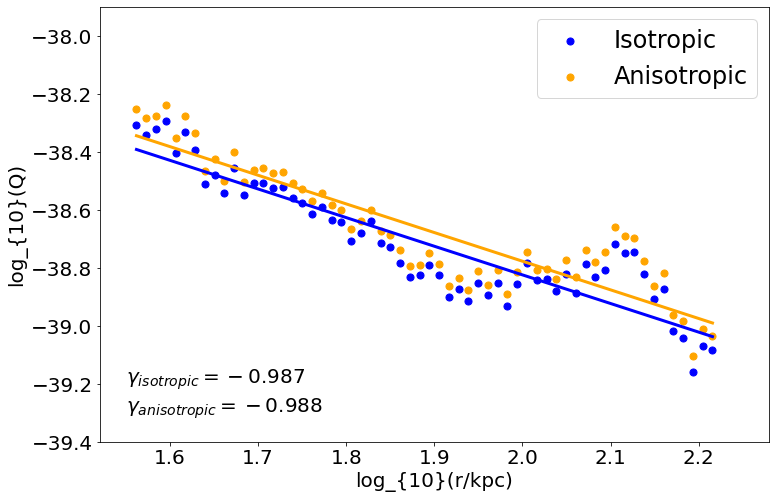

In [9]:
fitting_ind(2,36,40)

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]


147.51368098893767


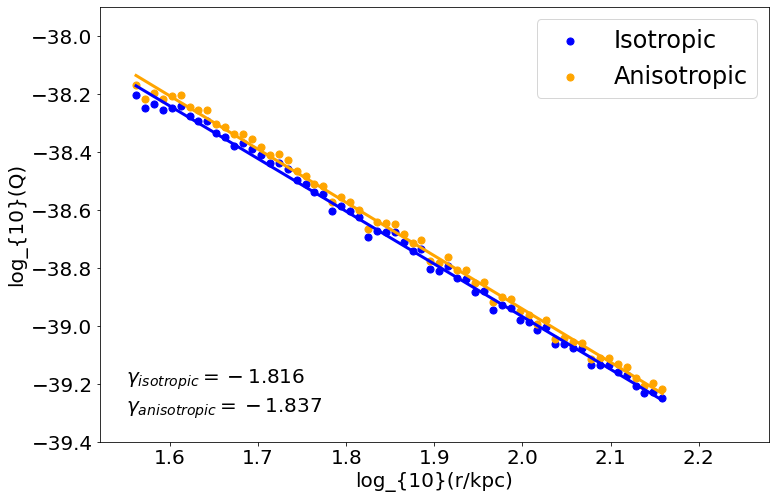

In [10]:
fitting_ind(3,36,40)

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]


131.7264128610522


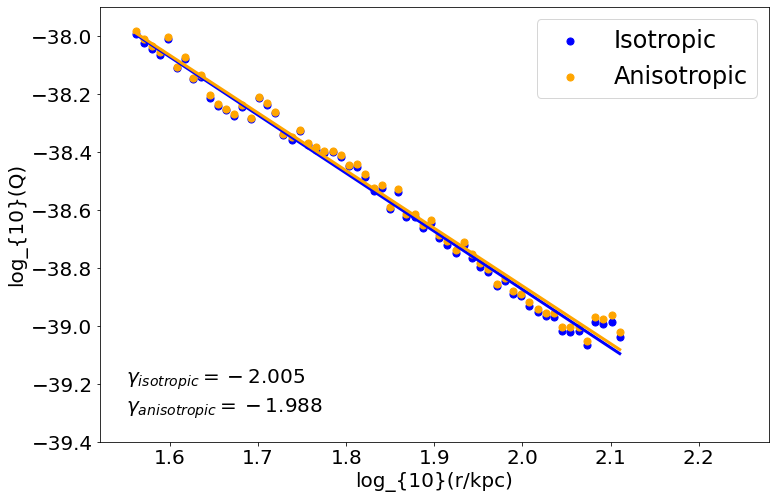

In [11]:
fitting_ind(23,36,40)

In [17]:
def gamma_50(minr,maxr):
    '''for first 50 halos
    '''
    power_law=np.zeros((Num_halo,2))

    for i in range(Num_halo):
        power_law[i,0]=power(h9[int(index[i])],minr,maxr)[0]
        power_law[i,1]=power(h9[int(index[i])],minr,maxr)[1]
    
    gamma_iso=power_law[:,0]
    gamma_ani=power_law[:,1]
    
    return gamma_iso, gamma_ani

In [18]:
def PF_results(minr,maxr):

    g_iso=gamma_50(minr,maxr)[0]
    g_ani=gamma_50(minr,maxr)[1]

    dgamma_iso=(np.mean(g_iso**2)-np.mean(g_iso)**2)/np.sqrt(Num_halo)
    dgamma_ani=(np.mean(g_ani**2)-np.mean(g_ani)**2)/np.sqrt(Num_halo)
    
    ps=50
    lw=3
    fs=20
    
    plt.figure(figsize=(10,8))
    plt.scatter(np.linspace(1,Num_halo,Num_halo),g_iso,label='Isotropic',s=ps,color='blue')
    plt.scatter(np.linspace(1,Num_halo,Num_halo),g_ani,label='Anisotropic',s=ps,color='orange')
    plt.plot(np.linspace(1,Num_halo,Num_halo),np.mean(g_iso)*np.ones(Num_halo),linewidth=lw,color='blue')
    plt.plot(np.linspace(1,Num_halo,Num_halo),np.mean(g_ani)*np.ones(Num_halo),linewidth=lw,color='orange')
    plt.legend(fontsize=fs,loc='lower left')
    plt.ylabel('$value\\ of\\ \gamma$',fontsize=fs)
    plt.xlabel('index of halos',fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.ylim([-3.0,-0.8])
    #plt.title('fitting of power-law for the first 50 halos')
    plt.text(35,-2.8,r'$ \bar{\gamma}_{iso}=%.2f\pm%.2f $'%(np.mean(g_iso),dgamma_iso),fontsize=17)
    plt.text(35,-2.9,r'$ \bar{\gamma}_{ani}=%.2f\pm%.2f $'%(np.mean(g_ani),dgamma_ani),fontsize=17)
    plt.savefig('PF results %s.pdf'%maxr,pad_inches=0.0)
    
    
    print(np.mean(g_iso),dgamma_iso)
    print(np.mean(g_ani),dgamma_ani)

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]


-1.8129987188764378 0.011491005127327588
-1.8244180495875322 0.012124624108876284


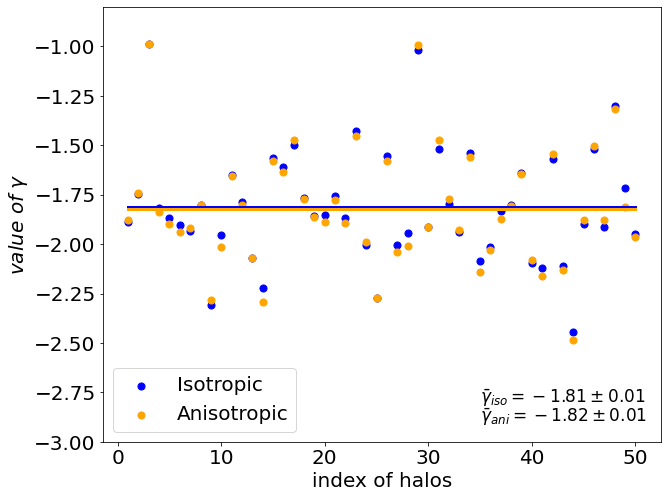

In [19]:
PF_results(36,40)

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]


-1.6837597606703616 0.010642829157810778
-1.6660516607140357 0.011694761217456114


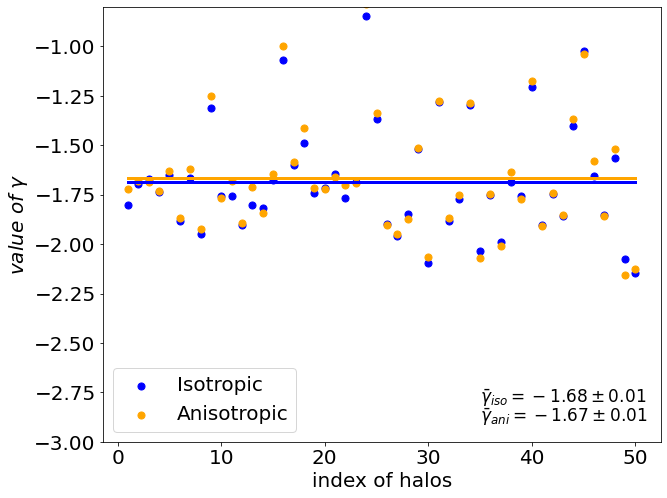

In [20]:
PF_results(36,0)

In [38]:
def Halo_visual(i,res,wid):
    
    h=h9[i]
    
    centering=pynbody.analysis.halo.center(h,vel=False)
    
    rhoplot=pynbody.plot.image(f9, qty='rho',units='kg m**-3',resolution=res, width=wid,denoise=True,threaded=False,noplot=True)
    
    def cb(x,pos):
        return 10**x
    
    ps=50
    lw=3
    fs=20
    
    plt.figure(figsize=(8,8))
    plt.imshow(np.log(rhoplot),cmap='CMRmap',vmin=-53,vmax=-48)
    cbr=plt.colorbar(fraction=0.1,shrink=0.87,format=ticker.FuncFormatter(cb))
    plt.xticks([int(res/10),int(res*3/10),int(res/2),int(res*7/10),int(res*9/10)],['-%s'%int(wid*2/5),'-%s'%int(wid*1/5),'0','%s'%int(wid*1/5),'%s'%int(wid*2/5)],fontsize=fs)
    plt.yticks([int(res/10),int(res*3/10),int(res/2),int(res*7/10),int(res*9/10)],['-%s'%int(wid*2/5),'-%s'%int(wid*1/5),'0','%s'%int(wid*1/5),'%s'%int(wid*2/5)],fontsize=fs)
    plt.xlabel('x (kpc)',fontsize=fs)
    plt.ylabel('y (kpc)',fontsize=fs)
    
    exr=float(profile(h,36)['rbins'].in_units('kpc')[100-40])
    
    thetac=np.linspace(0,2*np.pi,10000)
    rc=int(exr*res/wid)
    plt.plot(rc*np.cos(thetac)+int(res)/2,rc*np.sin(thetac)+int(res)/2,color='white')
    
    plt.text(1200,1900,r'$r_{c}=%.1f kpc$'%exr,fontsize=fs,color='white')
    
    cbr.set_label('$Density\\ (kg\\ m^{-3})$',fontsize=fs)
    cbr.ax.tick_params(labelsize=fs)
    
    plt.savefig('Halo visual %s.pdf'%i,bbox_inches='tight',pad_inches=0.0)
    
    centering.revert()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]


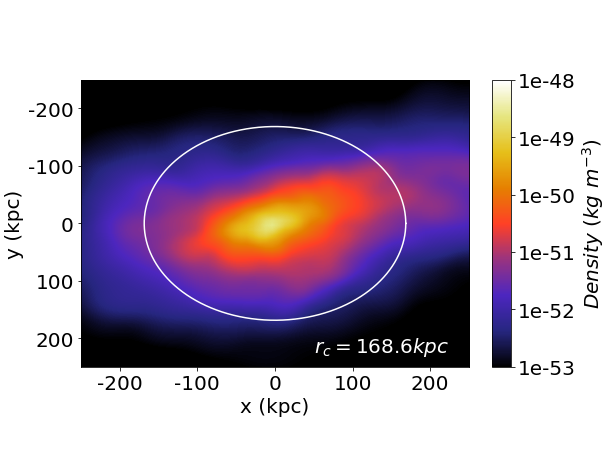

In [39]:
Halo_visual(2,2000,500)

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]


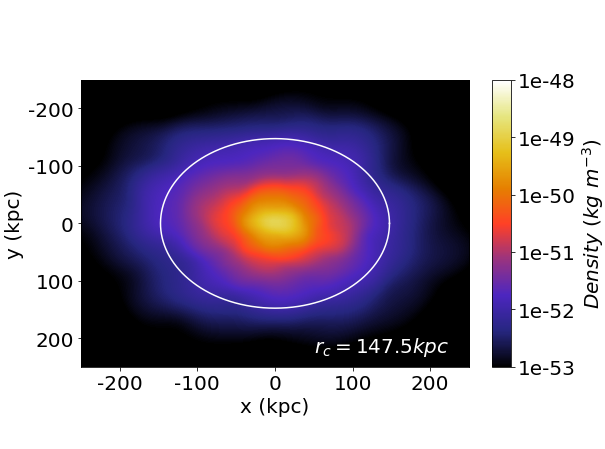

In [40]:
Halo_visual(3,2000,500)

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]


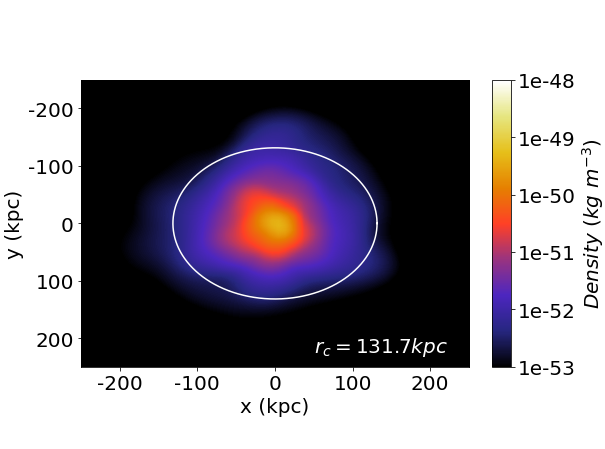

In [41]:
Halo_visual(23,2000,500)

In [21]:
def mean_gamma_50(minr):
    '''for first 50 halos
    '''
    power_law=np.zeros((Num_halo,2))

    for i in range(Num_halo):
        power_law[i,0]=power(h9[int(index[i])],minr,40)[0]
        power_law[i,1]=power(h9[int(index[i])],minr,40)[1]
    
    gamma_iso=power_law[:,0]
    gamma_ani=power_law[:,1]
    
    dgamma_iso=(np.mean(gamma_iso**2)-np.mean(gamma_iso)**2)/np.sqrt(Num_halo)
    dgamma_ani=(np.mean(gamma_ani**2)-np.mean(gamma_ani)**2)/np.sqrt(Num_halo)
    
    return np.mean(power_law[:,0]),dgamma_iso,np.mean(power_law[:,1]),dgamma_ani

In [22]:
gamma_test_iso=np.zeros(51)
gamma_test_ani=np.zeros(51)

for i in range(51):
    gamma_test_iso[i]=mean_gamma_50(i+25)[0]
    gamma_test_ani[i]=mean_gamma_50(i+25)[2]
    print(i)

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


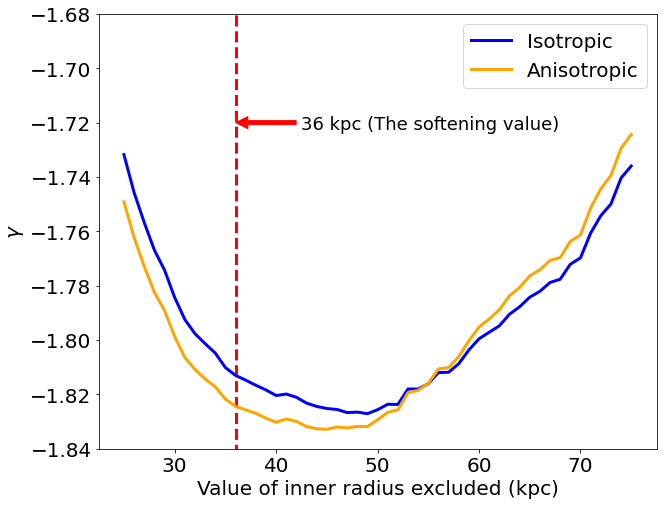

In [25]:
plt.figure(figsize=(10,8))
plt.plot(36*np.ones(1000),np.linspace(-1.86,-1.68,1000),linestyle='--',color='red',linewidth=3)
plt.plot(np.linspace(25,75,51),gamma_test_iso,label='Isotropic',color='blue',linewidth=3)
plt.plot(np.linspace(25,75,51),gamma_test_ani,label='Anisotropic',color='orange',linewidth=3)
plt.legend(fontsize=20)

plt.annotate('',xy=(36,-1.72),xytext=(42,-1.72),arrowprops=dict(facecolor='red',edgecolor='red',shrink=0.005))
plt.text(42.5,-1.7225,'36 kpc (The softening value)',fontsize=18)
plt.xlabel('Value of inner radius excluded (kpc)',fontsize=20)
plt.ylabel('$\gamma$',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([-1.84,-1.68])
plt.savefig('softning to halo power law.pdf',pad_inches=0.0)

In [8]:
h9[53].properties

{'omegaM0': 0.279,
 'omegaL0': 0.721,
 'boxsize': Unit("7.13e+04 kpc"),
 'a': 0.9999999999999996,
 'h': 0.701,
 'time': Unit("1.40e+01 kpc s km**-1"),
 'halo_id': 53,
 'mass': Unit("1.21e+13 Msol h**-1"),
 'pos': SimArray([47.489555 , 24.502245 ,  5.8998275], dtype=float32, 'Mpc**2 a**2 h**-2'),
 'mmean_200': Unit("1.04e+13 Msol h**-1"),
 'rmean_200': Unit("5.42e-01 Mpc a h**-1"),
 'mcrit_200': Unit("6.87e+12 Msol h**-1"),
 'rcrit_200': Unit("3.09e-01 Mpc a h**-1"),
 'mtop_200': Unit("8.52e+12 Msol h**-1"),
 'rtop_200': Unit("4.21e-01 Mpc a h**-1"),
 'contmass': 0.0,
 'group_len': 21015,
 'group_off': 3082690,
 'first_sub': 1223,
 'Nsubs': 4,
 'cont_count': 0,
 'mostboundID': 15953703,
 'children': array([1223, 1224, 1225, 1226])}